In [1]:
import scanpy as sc
import surgeon
sc.settings.set_figure_params(dpi=200)

Using TensorFlow backend.


In [13]:
condition_key = "batch"
cell_type_key = 'cell.type'
target_condition = "10X_v3"

# Loading mouse lung atlas datasets and data preparation

In [2]:
adata = sc.read("./data/lung_atlas/lung_atlas.h5ad")

#### normalizatiom and  Extracting HVGs 

In [8]:
sc.pp.normalize_per_cell(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata,n_top_genes=2000)

In [11]:
adata = adata[:,adata.var["highly_variable"]]

In [12]:
adata

View of AnnData object with n_obs × n_vars = 36373 × 2000 
    obs: 'batch', 'cell.type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [14]:
adata.obs[condition_key].value_counts()

0    26013
1    10360
Name: batch, dtype: int64

## visualization  of the original data

In [15]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


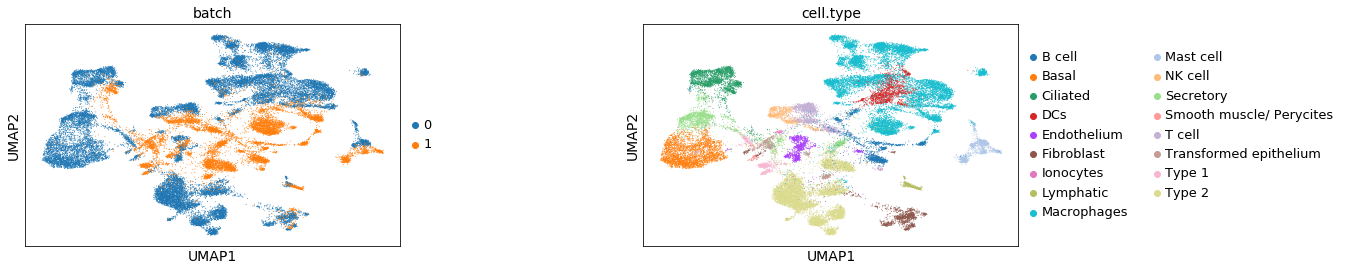

In [16]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (10X_v3) for training the newtork

In [41]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 411631 × 2000 
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cluster', 'louvain', 'louvain_R', 'mt_frac', 'n_counts', 'n_genes', 'sample', 'sample_type', 'study', 'subtissue'
    var: 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_counts-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'study_colors', 'batch_colors', 'sample_colors', 'cell_type_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

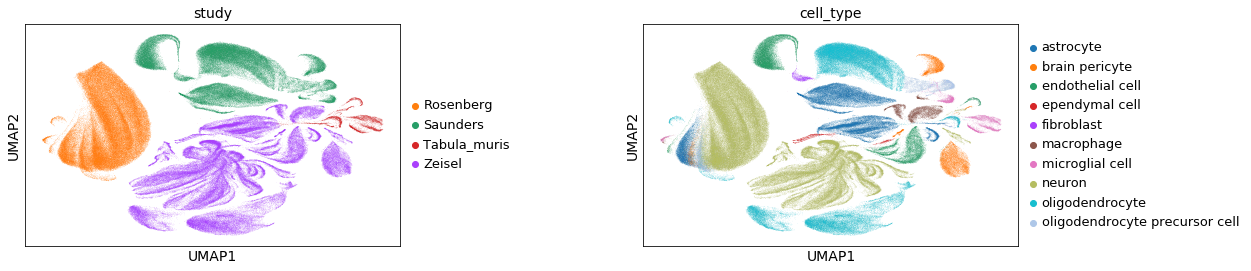

In [23]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [42]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 11741 × 2000 
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cluster', 'louvain', 'louvain_R', 'mt_frac', 'n_counts', 'n_genes', 'sample', 'sample_type', 'study', 'subtissue'
    var: 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_counts-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'study_colors', 'batch_colors', 'sample_colors', 'cell_type_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Train/Test Split

In [43]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [44]:
train_adata.shape, valid_adata.shape

((349886, 2000), (61745, 2000))

In [45]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [46]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/mouse_brain/",
                             dropout_rate=0.2,
                             output_activation='relu')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026048     concatenate_3[0][0]              
__________

## We assign each study to a numerical label 

In [47]:
train_adata.obs[condition_key].value_counts()

Zeisel          136649
Rosenberg       113143
Saunders         93400
Tabula_muris      6694
Name: study, dtype: int64

In [48]:
condition_encoder = {'Zeisel': 0, 'Rosenberg': 1, 'Saunders': 2, 'Tabula_muris': 3}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=300,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Train on 349886 samples, validate on 61745 samples
Epoch 1/300
 - 19s - loss: 82.7302 - kl_recon_loss: 82.7302 - val_loss: 76.5302 - val_kl_recon_loss: 76.5302
Epoch 2/300
 - 18s - loss: 76.8898 - kl_recon_loss: 76.8898 - val_loss: 73.9594 - val_kl_recon_loss: 73.9594
Epoch 3/300
 - 20s - loss: 75.9937 - kl_recon_loss: 75.9937 - val_loss: 73.4557 - val_kl_recon_loss: 73.4557
Epoch 4/300
 - 19s - loss: 75.3178 - kl_recon_loss: 75.3178 - val_loss: 72.9443 - val_kl_recon_loss: 72.9443
Epoch 5/300
 - 19s - loss: 74.8795 - kl_recon_loss: 74.8795 - val_loss: 72.9210 - val_kl_recon_loss: 72.9210
Epoch 6/300
 - 18s - loss: 74.5693 - kl_recon_loss: 74.5693 - val_loss: 73.0060 - val_kl_recon_loss: 73.0060
Epoch 7/300
 - 21s - loss: 74.2823 - kl_recon_loss: 74.2823 - val_loss: 72.0829 - val_kl_recon_loss: 72.0829
Epoch 8/300
 - 18s - loss: 74.0552 - kl_recon_loss: 74.0552 - val_loss: 72.0656 - val_kl_recon_loss: 72.0656
Epoch 9/300
 - 17s - loss: 73.8911 - kl_recon_loss: 73.8911 - val_loss: 72.25

In [29]:
network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2}

In [30]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [31]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9630 × 10 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

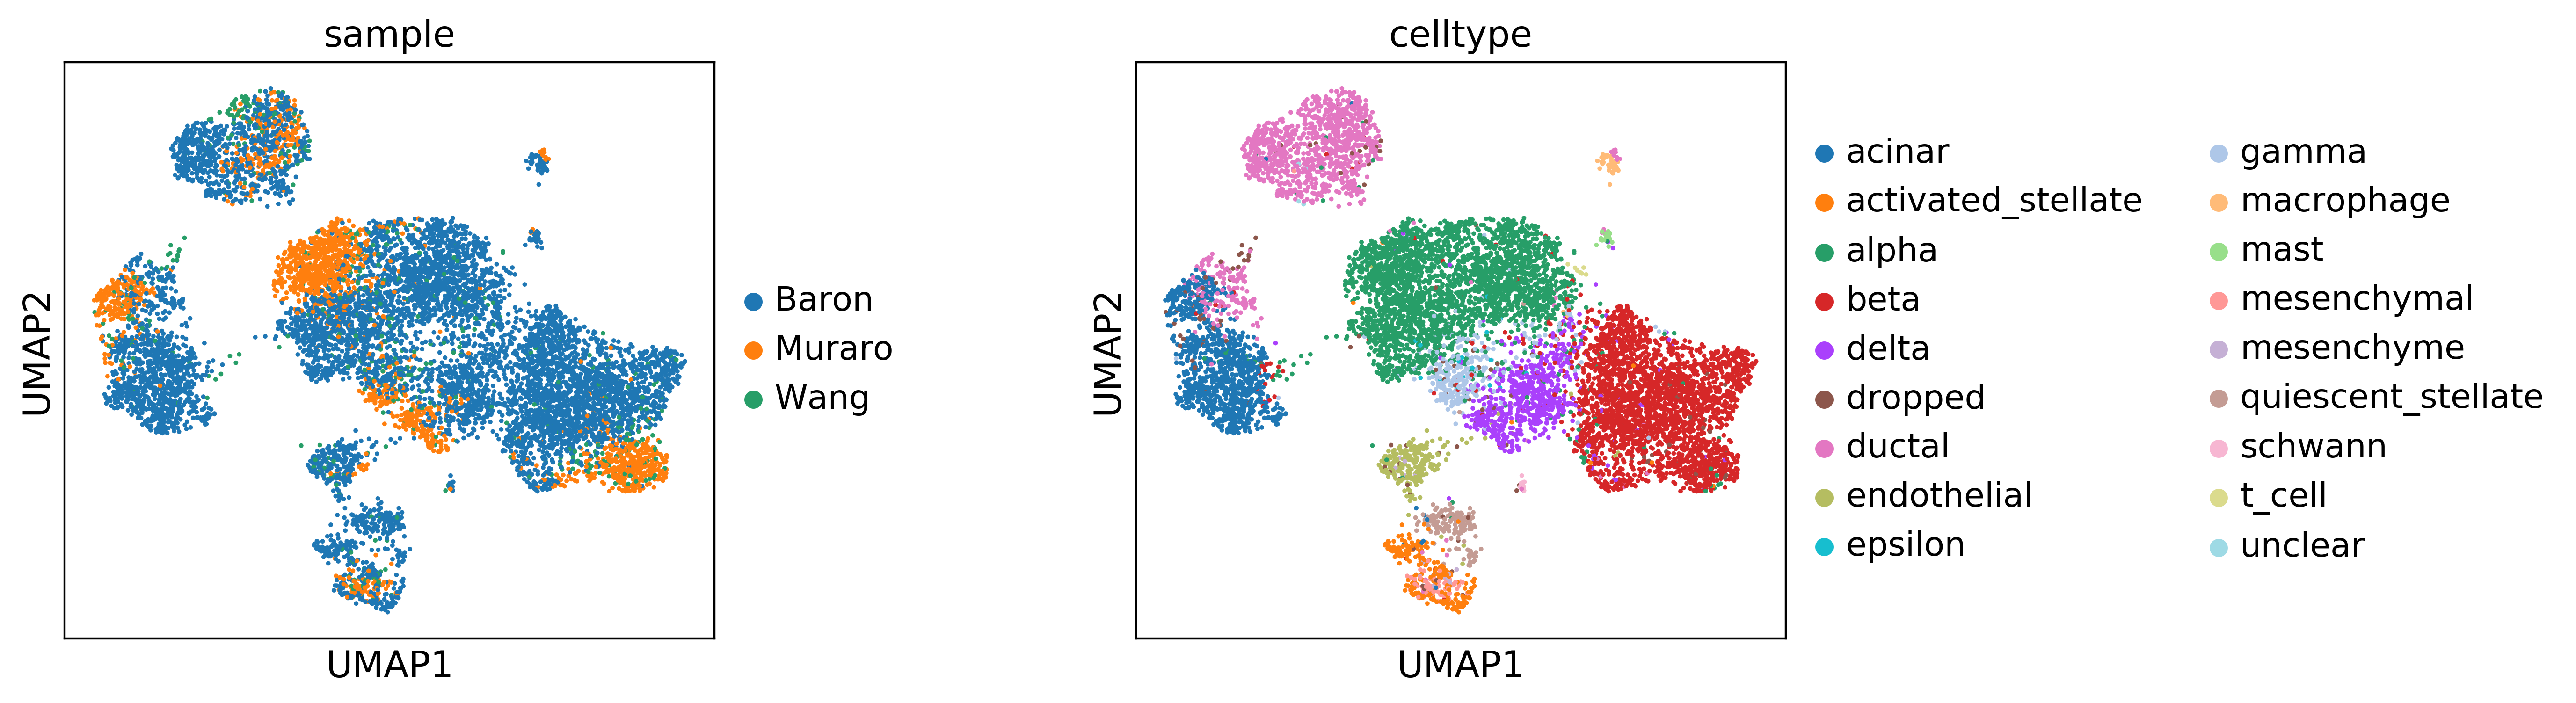

In [33]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [34]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

In [35]:
new_network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2, 'Segerstolpe': 3}

## Train with small new dataset containing out-of-sample condition

In [36]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [37]:
train_adata.shape, valid_adata.shape

((2858, 2448), (505, 2448))

In [38]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 2858 samples, validate on 505 samples
Epoch 1/100
 - 1s - loss: 1083.7845 - kl_recon_loss: 1083.7845 - val_loss: 1083.3455 - val_kl_recon_loss: 1083.3455
Epoch 2/100
 - 0s - loss: 1070.3194 - kl_recon_loss: 1070.3194 - val_loss: 1077.3954 - val_kl_recon_loss: 1077.3954
Epoch 3/100
 - 0s - loss: 1064.6094 - kl_recon_loss: 1064.6094 - val_loss: 1073.1115 - val_kl_recon_loss: 1073.1115
Epoch 4/100
 - 0s - loss: 1062.3106 - kl_recon_loss: 1062.3106 - val_loss: 1070.8145 - val_kl_recon_loss: 1070.8145
Epoch 5/100
 - 0s - loss: 1059.5966 - kl_recon_loss: 1059.5966 - val_loss: 1069.2387 - val_kl_recon_loss: 1069.2387
Epoch 6/100
 - 0s - loss: 1057.6339 - kl_recon_loss: 1057.6339 - val_loss: 1068.4489 - val_kl_recon_loss: 1068.4489
Epoch 7/100
 - 0s - loss: 1056.8883 - kl_recon_loss: 1056.8883 - val_loss: 1067.2987 - val_kl_recon_loss: 1067.2987
Epoch 8/100
 - 0s - loss: 1055.7281 - kl_recon_loss: 1055.7281 - val_loss: 1066.7826 - val_kl_recon_loss: 1066.7826
Epoch 9/100
 - 0s - loss:

## Projecting all data in to the latent space of the model 

In [39]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [40]:
adata.obs[condition_key].value_counts()

Baron          8569
Segerstolpe    3363
Muraro         2126
Wang            635
Name: sample, dtype: int64

In [41]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 14693 × 10 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [42]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

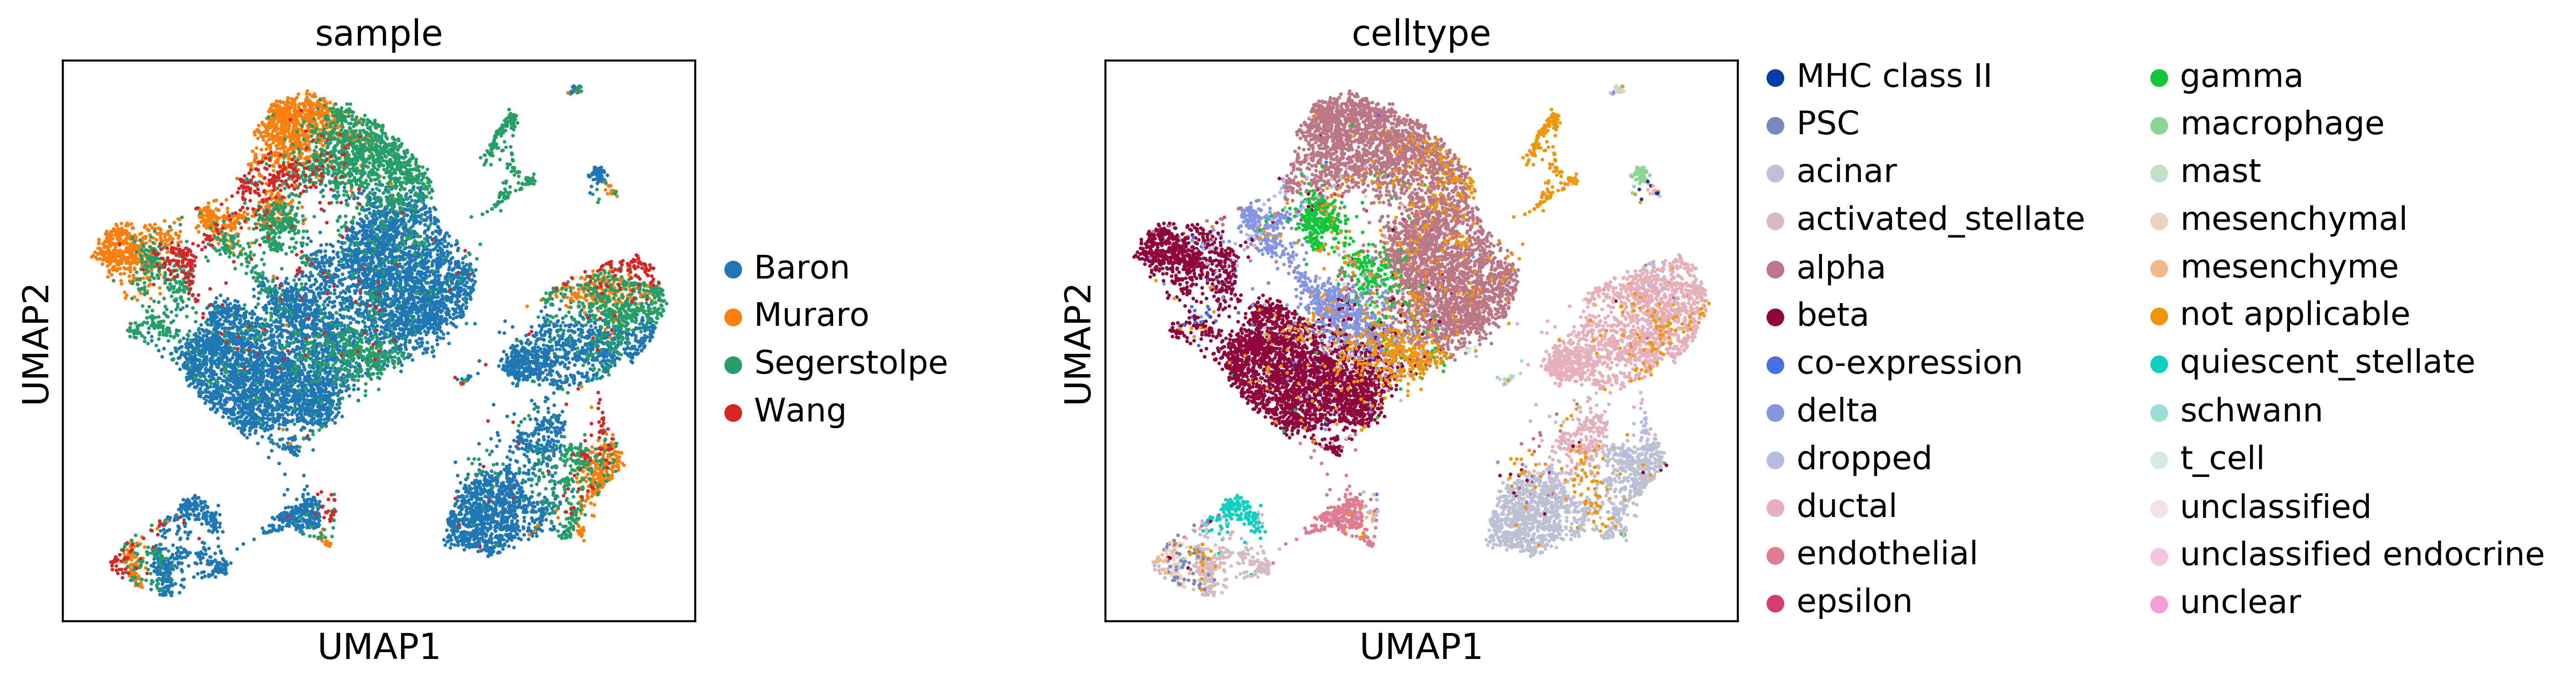

In [43]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)